# Synthetic Data Generation

After initializing an instance of EnergyModel class, synthetic data from a specified model can be generated using `generate_data` method. The short documentation for this method is included below:

    EnergyModel.generate_data(self, deltaT=0.00001, time_epoch=[(0, 1)])
    """Generate spike data and latent trajectories from a model.
    
    Parameters
    ----------
    deltaT : float
        Size of the time step in seconds for the numerical integration of the Langevin equation. 
    time_epoch : list
        List of N tuples, where N is the number of trials. Each tuple consists of trial start time and trial stop 
        time in seconds. For the case of absorbing boundary, stop time will be the maximum allowed time for the 
        trial to last (the trial will terminate before this time due to absorption, or at this time in an 
        arbitrary latent state). 
       
     Example: We want to generate 100 trials that start at t=0 and end on or before t=50, in this case time_epoch=[(0,50)]*100.
     
     Returns
     -------
     data_ISI : data in the ISI format
     time_bins : numpy array, dtype=np.ndarray
         For each trial, this array contains all time points on which the generated latent trajectories were recorded.
     latent_traj : numpy array, dtype=np.ndarray
         For each trial, this array contains a latent trajectory x(t)
     metadata : a dictionary with additional information
     
**In this exercise you will generate synthetic data and latent trajectories from the ramping dynamics and visualize the latent trajectories, firing rate along these trajectories, and the spike rasters.**

In [ ]:
# Package installation - needed to run in google Collab. Skip this cell if you use local jupyter notebook
!pip install git+https://github.com/engellab/neuralflow

In [1]:
# Import packages 
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import scipy

In [2]:
# Cell 1: create an instance of EnergyModel class and generate the data from it

# Specifies the parameters of the EnergyModel: ramping dynamics (linear potential), narrow 
# zero-centered p0(x) distribution, 2 neurons with linear and non-linear firing rate functions
EnergyModelParams={'num_neuron':2,
               'peq_model':{"model": "linear_pot", "params": {"slope": -2.65}},
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'D0': 0.56,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}},
                               {"model": "sinus", "params": {"bias": 50, "amp": 40}}],
               'boundary_mode':'absorbing', 
               'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}},   
               'verbose':True
               }

# Create an instance of EnergyModel class
em_data_gen=neuralflow.EnergyModel(**EnergyModelParams)

# Generate spike data from this model
num_trial = 100
data_ISI, time_bins, latent_traj, _=em_data_gen.generate_data(deltaT=0.0001,time_epoch=[(0,50)]*num_trial)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.24it/s]


We just generated 100 trials of spike data (in the ISI format), and 100 latent trajecotries from the ramping dynamics. For visualization purposes, let us select 2 trials with the longest and 2 trials with the shortest duration. Let us plot latent trajectories for the selected 4 trials.

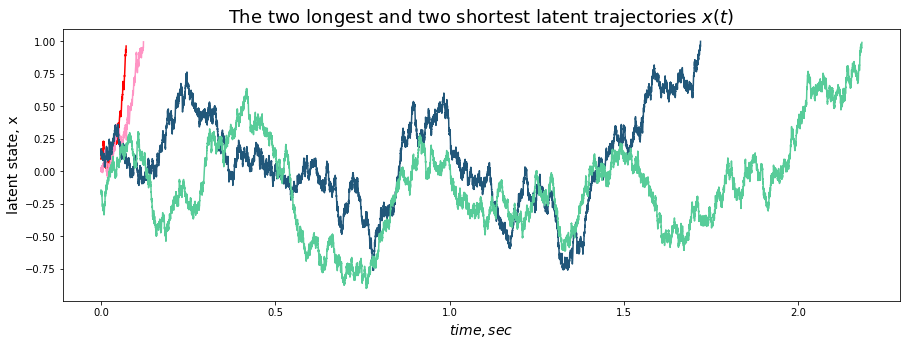

In [13]:
# Cell 2

# First, find the duration for all trials
trial_durations = np.zeros(num_trial)
for i in range(num_trial):
    trial_durations[i] = time_bins[i][-1]-time_bins[i][0]

#Argsort the trial durations
ind_sort = np.argsort(trial_durations)

#Next, find the indices of two shortest and two longest trials
selected_trials = np.concatenate((ind_sort[:2],ind_sort[-2:]))

# Let us plot the latent trajectories for the selected trials.
color_set = [ [1,0,0] , [1, 0.58, 0.77], [0.13, 0.34, 0.48], [0.34, 0.8, 0.6]]
fig=plt.figure(figsize=(15,5))

plt.title(r'The two longest and two shortest latent trajectories $x(t)$', fontsize=18)
plt.ylabel('latent state, x', fontsize=14)
plt.xlabel(r'$time, sec$', fontsize=14)

for i,trial in enumerate(selected_trials):
    plt.plot(time_bins[trial],latent_traj[trial],color=color_set[i])

Let us now plot the firing rate for the 2nd neuron along these latent trajectoies

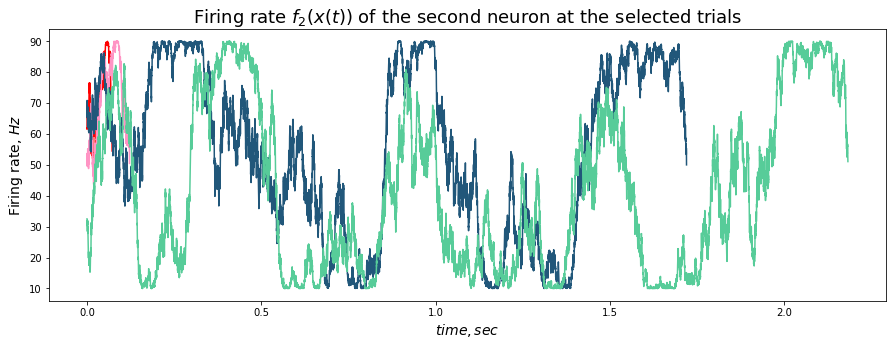

In [6]:
# Cell 3

neuron_id = 1

# First, we need to interpolate firing rate function in between the grid points 
# (since latent trajectory can take arbitrary values), and the firing rate function f2(x)
# is only defined at grid points
fr_interpolate = scipy.interpolate.interp1d(em_data_gen.x_d_,em_data_gen.fr_[:,neuron_id])


#Now plot it
fig=plt.figure(figsize=(15,5))
plt.title(r'Firing rate $f_2(x(t))$ of the second neuron at the selected trials', fontsize=18)
plt.ylabel('Firing rate, $Hz$', fontsize=14)
plt.xlabel(r'$time, sec$', fontsize=14)

for i,trial in enumerate(selected_trials):
    plt.plot(time_bins[trial],fr_interpolate(latent_traj[trial]),color=color_set[i])

Finally, let us plot spike rasters of the 2nd neuron on the selected trials

([<matplotlib.axis.YTick at 0x154b3d7c0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

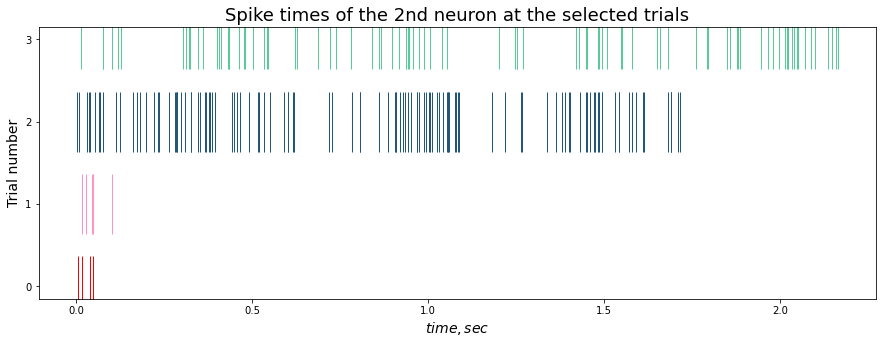

In [12]:
# Cell 4

# First, we need to calculate the spike times of the 2nd neurons using the ISI format.
spikes_single_neuron = np.empty((selected_trials.size,),dtype=np.ndarray)

# On each trial, first calculate spike times of all of the neurons, and then select the spike times of the 
# second neuron 
for i,trial in enumerate(selected_trials):
    # Spike times of all neurons
    spikes_all = np.cumsum(data_ISI[trial,0])
    
    # Now filter the spike times by neuron_id
    spikes_single_neuron[i] = spikes_all[data_ISI[trial,1]==neuron_id]
    
# Plot it
fig=plt.figure(figsize=(15,5))
plt.title('Spike times of the 2nd neuron at the selected trials', fontsize = 18)
plt.ylabel('Trial number', fontsize=14)
plt.xlabel(r'$time, sec$', fontsize=14)

for i,trial in enumerate(selected_trials):
    plt.plot(spikes_single_neuron[i],i*np.ones(spikes_single_neuron[i].size),'|',color=color_set[i],markersize=60)
plt.yticks([0,1,2,3])

Let us plot firing rates and spike rasters together. This way you can visually inspect the spike raster and make sure that you observe a lot of spikes when the firing rate is high, and you observe little number of spikes when the firing rate is low.

([<matplotlib.axis.YTick at 0x155a9d3a0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

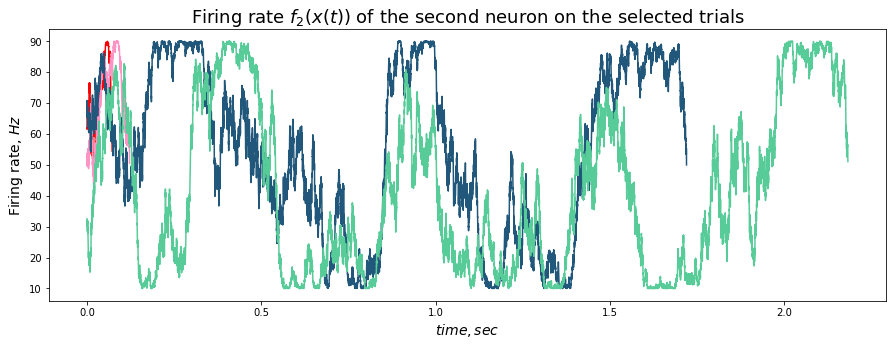

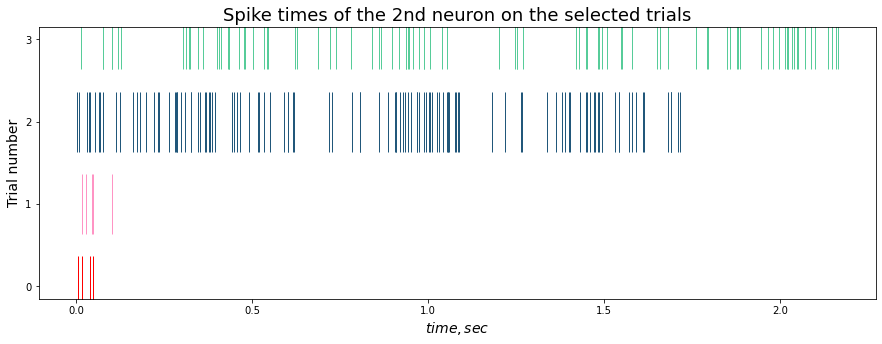

In [9]:
# Cell 5

# Plot firing rates for neuron 2
fig=plt.figure(figsize=(15,5))
plt.title(r'Firing rate $f_2(x(t))$ of the second neuron on the selected trials', fontsize=18)
plt.ylabel('Firing rate, $Hz$', fontsize=14)
plt.xlabel(r'$time, sec$', fontsize=14)

for i,trial in enumerate(selected_trials):
    plt.plot(time_bins[trial],fr_interpolate(latent_traj[trial]),color=color_set[i])
    
# Plot spike rasters for neuron 2
fig=plt.figure(figsize=(15,5))
plt.title('Spike times of the 2nd neuron on the selected trials', fontsize = 18)
plt.ylabel('Trial number', fontsize=14)
plt.xlabel(r'$time, sec$', fontsize=14)

for i,trial in enumerate(selected_trials):
    plt.plot(spikes_single_neuron[i],i*np.ones(spikes_single_neuron[i].size),'|',color=color_set[i],markersize=60)
plt.yticks([0,1,2,3])

Let us know plot the firing rates $f(x(t))$ of the 1st and the 2nd neurons during the trial with the longest duration.

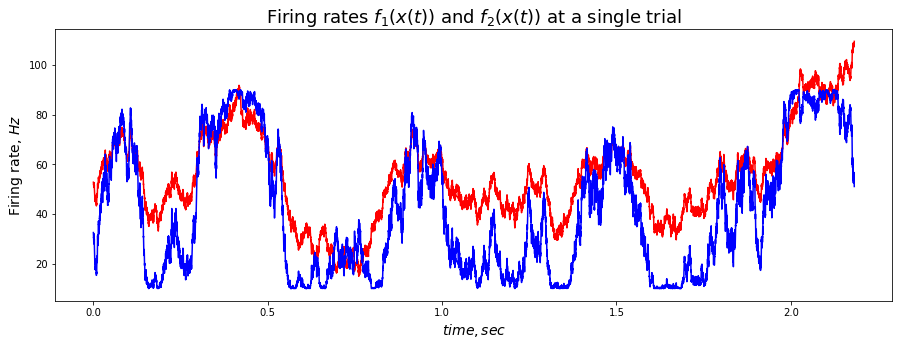

In [14]:
# Cell 6

trial_id = selected_trials[-1]

# First, we need to interpolate firing rate function in between the grid points 
# (since latent trajectory can take arbitrary values)
fr1_interpolate = scipy.interpolate.interp1d(em_data_gen.x_d_,em_data_gen.fr_[:,0])
fr2_interpolate = scipy.interpolate.interp1d(em_data_gen.x_d_,em_data_gen.fr_[:,1])


#Now plot it
fig=plt.figure(figsize=(15,5))
plt.title(r'Firing rates $f_1(x(t))$ and $f_2(x(t))$ at a single trial', fontsize=18)
plt.ylabel('Firing rate, $Hz$', fontsize=14)
plt.xlabel(r'$time, sec$', fontsize=14)

plt.plot(time_bins[trial_id],fr1_interpolate(latent_traj[trial_id]),color='red')
plt.plot(time_bins[trial_id],fr2_interpolate(latent_traj[trial_id]),color='blue')